In [403]:
import pandas as pd
import numpy as np

In [404]:
bogota = pd.read_csv('bogota.csv')
bogota

,FECHA_DIAGNOSTICO,CASO,CASOS_ACUMULADOS,RECUPERADO,RECUPERADOS_ACUMULADOS,FALLECIDOS,FALLECIDOS_ACUMULADOS
0,2020-03-06,1,1,1,1,0,0
1,2020-03-07,0,1,0,1,0,0
2,2020-03-08,0,1,0,1,0,0
3,2020-03-09,0,1,0,1,0,0
4,2020-03-10,2,3,2,3,0,0
...,...,...,...,...,...,...,...
678,2022-01-13,8075,1565063,168,1484374,5,27949
679,2022-01-14,7942,1573005,174,1484548,1,27950
680,2022-01-15,6754,1579759,235,1484783,7,27957
681,2022-01-16,5333,1585092,31,1484814,2,27959


In [405]:
bogota_cases = bogota.drop(['CASO', 'RECUPERADO', 'RECUPERADOS_ACUMULADOS','FALLECIDOS','FALLECIDOS_ACUMULADOS'],axis=1)
bogota_cases

,FECHA_DIAGNOSTICO,CASOS_ACUMULADOS
0,2020-03-06,1
1,2020-03-07,1
2,2020-03-08,1
3,2020-03-09,1
4,2020-03-10,3
...,...,...
678,2022-01-13,1565063
679,2022-01-14,1573005
680,2022-01-15,1579759
681,2022-01-16,1585092


In [406]:
bogota_cases.set_index('FECHA_DIAGNOSTICO', inplace = True)
bogota_cases

,CASOS_ACUMULADOS
FECHA_DIAGNOSTICO,
2020-03-06,1
2020-03-07,1
2020-03-08,1
2020-03-09,1
2020-03-10,3
...,...
2022-01-13,1565063
2022-01-14,1573005
2022-01-15,1579759


In [407]:
train = bogota_cases[:138]
train

,CASOS_ACUMULADOS
FECHA_DIAGNOSTICO,
2020-03-06,1
2020-03-07,1
2020-03-08,1
2020-03-09,1
2020-03-10,3
...,...
2020-07-17,63192
2020-07-18,65655
2020-07-19,68127


In [408]:
test = bogota_cases[138:138+14]
test

,CASOS_ACUMULADOS
FECHA_DIAGNOSTICO,
2020-07-22,77437
2020-07-23,79880
2020-07-24,83604
2020-07-25,86717
2020-07-26,89002
2020-07-27,92710
2020-07-28,96653
2020-07-29,99736
2020-07-30,103354


In [409]:
from sklearn.preprocessing import MinMaxScaler

In [410]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [411]:
train_scaled =scaler.transform(train)
test_scaled = scaler.transform(test)

In [412]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [413]:
window_size= 30
n_features= 1
batch_size = 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length= window_size, batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train))
print("Total number of samples in the generated data = ", len(train_generator))

Total number of samples in the original training data =  138
Total number of samples in the generated data =  108


In [414]:
x_train, y_train = train_generator[0]
x_train.shape
y_train.shape

(1, 1)

In [417]:
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=len(test)-1 ,batch_size=batch_size)
print("Total number of samples in the original training data = ", len(test))
print("Total number of sambles in the generated data", len(test_generator))

Total number of samples in the original training data =  14
Total number of sambles in the generated data 1


In [418]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import RootMeanSquaredError

In [419]:
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(window_size, n_features)))
model.add(LSTM(300, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 30, 300)           362400    
                                                                 
 lstm_25 (LSTM)              (None, 300)               721200    
                                                                 
 dense_12 (Dense)            (None, 1)                 301       
                                                                 
Total params: 1,083,901
Trainable params: 1,083,901
Non-trainable params: 0
_________________________________________________________________


In [420]:
history=model.fit(train_generator, validation_data = test_generator, epochs=100)

Epoch 1/100
108/108 [==============================] - 20s 156ms/step - loss: 0.0436 - root_mean_squared_error: 0.2089 - val_loss: 0.2441 - val_root_mean_squared_error: 0.4941
Epoch 2/100
108/108 [==============================] - 17s 155ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.3985 - val_root_mean_squared_error: 0.6312
Epoch 3/100
108/108 [==============================] - 15s 141ms/step - loss: 1.0743e-04 - root_mean_squared_error: 0.0104 - val_loss: 0.4631 - val_root_mean_squared_error: 0.6805
Epoch 4/100
108/108 [==============================] - 15s 141ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.3887 - val_root_mean_squared_error: 0.6235
Epoch 5/100
108/108 [==============================] - 16s 144ms/step - loss: 5.0496e-05 - root_mean_squared_error: 0.0071 - val_loss: 0.4044 - val_root_mean_squared_error: 0.6359
Epoch 6/100
108/108 [==============================] - 16s 144ms/step - loss: 3.6319e-05 - root_mean_squared_err

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

In [ ]:
import matplotlib.pyplot as plt

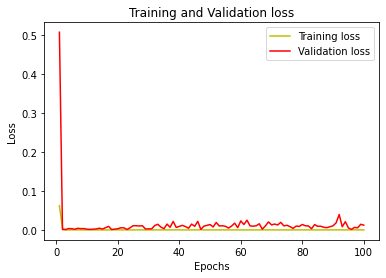

In [ ]:
plt.plot(epochs, loss, 'y',label='Training loss')
plt.plot(epochs, val_loss, 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

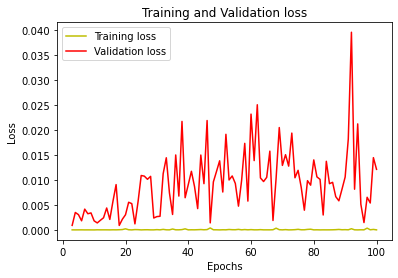

In [ ]:
plt.plot(epochs[2:], loss[2:], 'y',label='Training loss')
plt.plot(epochs[2:], val_loss[2:], 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np

predictions = []

first_batch = train_scaled[-window_size:]
current_batch = first_batch.reshape((1, window_size, n_features))


In [ ]:
future = 60
for i in range(future):
    current_pred = model.predict(current_batch)[0]

    predictions.append(current_pred)
    
    current_batch_rmv_first = current_batch[:,1:,:]

    current_batch = np.append(current_batch_rmv_first,[[current_pred]], axis=1)

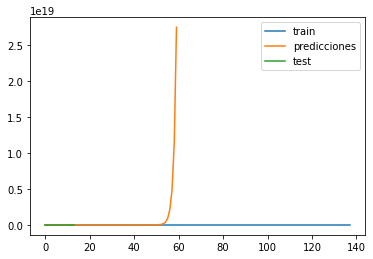

In [ ]:
predictions_actual_scale = scaler.inverse_transform(predictions)
test_data_actual_scale = scaler.inverse_transform(test_scaled)
train_data_actual_scale =scaler.inverse_transform(train_scaled)

plt.plot(train_data_actual_scale, label='train')
plt.plot(predictions_actual_scale, label='predicciones')
plt.plot(test_data_actual_scale, label='test')
plt.legend()

In [ ]:
test_prediction=model.predict(test_scaled)
test_prediction_data_actual_scale = scaler.inverse_transform(test_prediction)


In [ ]:
train_data_actual_scale[:,0].shape

(138,)

In [ ]:
rng1 = pd.date_range('2020-03-06', periods=138, freq='D')
rng1.shape

(138,)

In [ ]:
df = pd.DataFrame({'Date':rng1,'train':train_data_actual_scale[:,0]})
df
df.set_index('Date', inplace = True)
df

,train
Date,
2020-03-06,1.0
2020-03-07,1.0
2020-03-08,1.0
2020-03-09,1.0
2020-03-10,3.0
...,...
2020-07-17,63192.0
2020-07-18,65655.0
2020-07-19,68127.0


In [ ]:
rng2 = pd.date_range('2020-07-22', periods=len(test), freq='D')
rng2.shape

(14,)

In [ ]:
df2 = pd.DataFrame({'Date':rng2,'Test':test_prediction_data_actual_scale[:,0]})
df2.set_index('Date', inplace = True)
df2

,Test
Date,
2020-07-22,6330.457520
2020-07-23,6466.247070
2020-07-24,6673.098633
2020-07-25,6846.137695
2020-07-26,6973.400391
2020-07-27,7180.312500
2020-07-28,7400.813965
2020-07-29,7573.659180
2020-07-30,7776.903809


In [ ]:
predictions_actual_scale[:,0].shape

(60,)

In [ ]:
rng3 = pd.date_range('2020-08-04', periods=future, freq='D')
rng3.shape

(60,)

In [ ]:
df3 = pd.DataFrame({'Date':rng3,'Predictions':predictions_actual_scale[:,0]})
df3.set_index('Date', inplace = True)
df3

,Predictions
Date,
2020-08-04,7.644357e+04
2020-08-05,7.956999e+04
2020-08-06,8.287960e+04
2020-08-07,8.645436e+04
2020-08-08,9.072669e+04
2020-08-09,9.503582e+04
2020-08-10,9.978663e+04
2020-08-11,1.050683e+05
2020-08-12,1.110111e+05


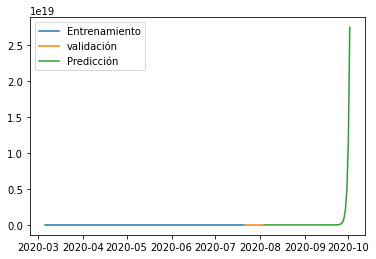

In [ ]:
plt.plot(df, label='Entrenamiento')
plt.plot(df2, label='validación')
plt.plot(df3, label='Predicción')
plt.legend()